# Project

Herman Autore

This is based on `scikit-survival`'s [introduction noteboook](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb).

## The Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lifelines import AalenJohansenFitter, KaplanMeierFitter
from sksurv.compare import compare_survival
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.nonparametric import kaplan_meier_estimator

data_x, data_y = load_veterans_lung_cancer()

Entire response variable

In [2]:
data_y

array([( True,  72.), ( True, 411.), ( True, 228.), ( True, 126.),
       ( True, 118.), ( True,  10.), ( True,  82.), ( True, 110.),
       ( True, 314.), (False, 100.), ( True,  42.), ( True,   8.),
       ( True, 144.), (False,  25.), ( True,  11.), ( True,  30.),
       ( True, 384.), ( True,   4.), ( True,  54.), ( True,  13.),
       (False, 123.), (False,  97.), ( True, 153.), ( True,  59.),
       ( True, 117.), ( True,  16.), ( True, 151.), ( True,  22.),
       ( True,  56.), ( True,  21.), ( True,  18.), ( True, 139.),
       ( True,  20.), ( True,  31.), ( True,  52.), ( True, 287.),
       ( True,  18.), ( True,  51.), ( True, 122.), ( True,  27.),
       ( True,  54.), ( True,   7.), ( True,  63.), ( True, 392.),
       ( True,  10.), ( True,   8.), ( True,  92.), ( True,  35.),
       ( True, 117.), ( True, 132.), ( True,  12.), ( True, 162.),
       ( True,   3.), ( True,  95.), ( True, 177.), ( True, 162.),
       ( True, 216.), ( True, 553.), ( True, 278.), ( True,  1

Subset of response variable

In [3]:
pd.DataFrame.from_records(data_y[[11, 5, 32, 13, 23]], index=range(1, 6))

,Status,Survival_in_days
1,True,8.0
2,True,10.0
3,True,20.0
4,False,25.0
5,True,59.0


## Unstratified survival function

Text(0.5, 0, 'time $t$')

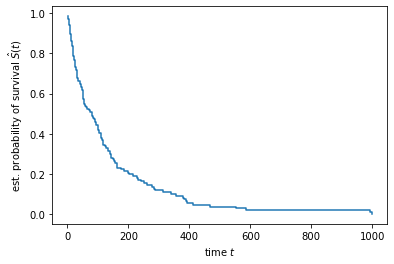

In [4]:
time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Survival function by treatment type

In [5]:
data_x["Treatment"].value_counts()

standard    69
test        68
Name: Treatment, dtype: int64

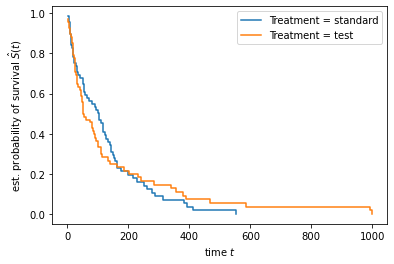

In [6]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

_Visually comparing estimated survival curves in order to assess whether there is a difference in survival between groups is usually not recommended, because it is highly subjective. Statistical tests such as the [log-rank test](https://en.wikipedia.org/wiki/Log-rank_test) are usually more appropriate._

## Compare survival functions using log-rank test

In [7]:
chisq, pvalue, stats, cov = compare_survival(data_y, data_x["Treatment"], return_stats=True)

In [8]:
chisq

0.008227343202350305

In [9]:
pvalue

0.9277272333400758

In [10]:
stats

,counts,observed,expected,statistic
group,,,,
standard,69,64,64.500197,-0.500197
test,68,64,63.499803,0.500197


We see from the results that the treatment and control groups are not different.

## Survival function by cell type

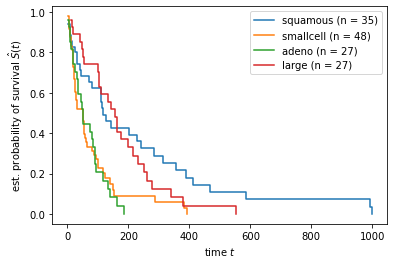

In [11]:
for value in data_x["Celltype"].unique():
    mask = data_x["Celltype"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(data_y["Status"][mask],
                                                           data_y["Survival_in_days"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [12]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [13]:
chisq, pvalue, stats, cov = compare_survival(data_y, data_x["Celltype"], return_stats=True)

In [14]:
chisq

25.40370034578536

In [15]:
pvalue

1.271245939006091e-05

In [16]:
stats

,counts,observed,expected,statistic
group,,,,
adeno,27,26,15.693765,10.306235
large,27,26,34.549478,-8.549478
smallcell,48,45,30.102079,14.897921
squamous,35,31,47.654678,-16.654678


## Competing Risk Analysis

We can see which cell type is the most lethal by doing a competing risk analysis. This can be done using the `lifelines` package in Python.

### Modify data to a `lifelines`-compatible format

In [17]:
celltypes = data_x['Celltype']
n = len(celltypes)
censored_cases = [x for x,y in data_y]
survival_times = [y for x,y in data_y] + np.random.normal(0,1,n)

In [18]:
# Replace celltypes with integers >= 1
observed_events = data_x['Celltype'].to_numpy()
i = 1
eventMap = {}
for celltype in data_x['Celltype'].unique():
    mask = observed_events == celltype
    observed_events[mask] = i
    eventMap[celltype] = i
    i += 1

eventMapR = {v : k for k,v in eventMap.items()}

# Replace celltypes with 0 if that case was censored
indexForCensored = np.argwhere( censored_cases == False)
observed_events[ indexForCensored ] = 0
observed_events = observed_events.tolist()

### Analysis

       timeline  km curve  aj CIF_squamous  aj CIF_smallcell  aj CIF_adeno  \
0     -0.656048  0.007299         0.000000          0.000000      0.000000   
1      1.688631  0.014599         0.007299          0.000000      0.000000   
2      1.829876  0.021898         0.007299          0.007299      0.000000   
3      2.590035  0.029197         0.007299          0.007299      0.007299   
4      4.178572  0.036496         0.007299          0.014599      0.007299   
..          ...       ...              ...               ...           ...   
132  466.576122  0.970803         0.226277          0.350365      0.197080   
133  552.821974  0.978102         0.226277          0.350365      0.197080   
134  585.608605  0.985401         0.233577          0.350365      0.197080   
135  991.048048  0.992701         0.240876          0.350365      0.197080   
136  997.954482  1.000000         0.248175          0.350365      0.197080   

     aj CIF_large  
0        0.000000  
1        0.000000  
2  

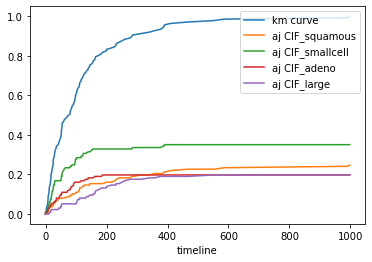

In [19]:
# Fit KM function on all events
km = KaplanMeierFitter()
km.fit(durations = survival_times,
       event_observed = observed_events)

results = pd.DataFrame()
results['timeline'] = km.cumulative_density_.index
results['km curve'] = km.cumulative_density_['KM_estimate'].values

# Fit AJ function on specific events
for event_of_interest in ['squamous', 'smallcell', 'adeno', 'large']:
    event_of_interest = eventMap[event_of_interest]

    aj = AalenJohansenFitter()
    aj.fit(durations = survival_times,
           event_observed = observed_events,
           event_of_interest = event_of_interest)

    results[f'aj CIF_{eventMapR[event_of_interest]}'] = aj.cumulative_density_[f'CIF_{event_of_interest}'].values

# Summary. These are the cumulative incidence functions, F_{j}(t). To get the survival function, S(t), we do 1-F(t).
print(results)

results.plot(x='timeline')

# The sum of the individual event functions equals the KM curve.
results2 = pd.DataFrame()
results2['km curve'] = results['km curve']
results2['aj sum'] = results[results.columns[2:]].sum(axis=1)

survfuncs = pd.DataFrame()